# Project 3: Recommendation Systems

## Group Members
- Shaira Alam

- Vani Agrawal 

- Dhakshina Ilango

# Imports 

In [2]:
! pip install surprise

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-win_amd64.whl size=1132995 sha256=9221b598d9436f66247032ad9acaa833a1612df109e10dfd7db63524b63255f5
  Stored in directory: c:\users\dhakshina\appdata\local\pip\cache\wheels\a5\ca\a8\4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from sklearn.metrics import roc_curve, auc

In [5]:
df_ratings = pd.read_csv('C:/Users/Dhakshina/Desktop/ECE Data Mining/Project 3/Data/ratings.csv', index_col=None)
df_ratings.drop(columns=['Unnamed: 0'], inplace=True)
df_ratings.head()

,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


Creation of Matrix R

In [7]:
R = df_ratings.pivot_table(index='userId', columns='movieId', values='rating')
R

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
R.fillna(0.0,inplace=True)
R

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Question 1

Explore the Dataset: In this question, we explore the structure of the data. 

A. Compute the sparsity of the movie rating dataset:  <br><br> ${Sparsity} = Total number of available ratings \div Total number of possible ratings$

In [10]:
total_available_ratings = R[R!=0].count().sum()
total_possible_ratings = R.shape[0] * R.shape[1]
sparsity = total_available_ratings/total_possible_ratings
print("Sparsity", sparsity)

Sparsity 0.016999683055613623


B. Plot a histogram showing the frequency of the rating values: Bin the raw rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R that fall within each bin and use this count as the height of the vertical axis for that particular bin. <br><br>Comment on the shape of the histogram.
It is a left Skewed Histogram. 

It is a left Skewed Histogram. 

In [11]:
ratings_array = R.values.flatten()
ratings_array

array([4., 0., 4., ..., 0., 0., 0.])

In [12]:
# Remove 0.0 values from the ratings_array
ratings_array = ratings_array[ratings_array != 0.0]

In [13]:
# Bins of width 0.5
bins = np.arange(0,5.5,0.5)

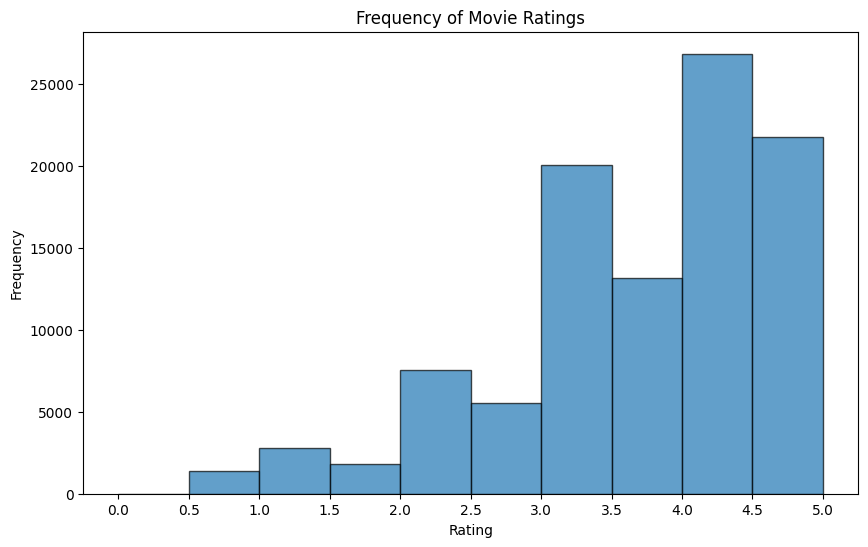

In [14]:
# Plot the histogram 
plt.figure(figsize=(10,6))
plt.hist(ratings_array, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Movie Ratings')
plt.xticks(np.arange(0,5.5,0.5))
plt.show()

C. Plot the distribution of the number of ratings received among movies: The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend is expected.

In [15]:
ratings_per_movie = R.astype(bool).sum(axis=0)

In [16]:
# Total no of ratings per movie 
ratings_per_movie

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Length: 9724, dtype: int64

In [17]:
# Sort in Decreasing Order 
sorted_movies = ratings_per_movie.sort_values(ascending=False)
sorted_movies

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
4093        1
4089        1
58351       1
4083        1
193609      1
Length: 9724, dtype: int64

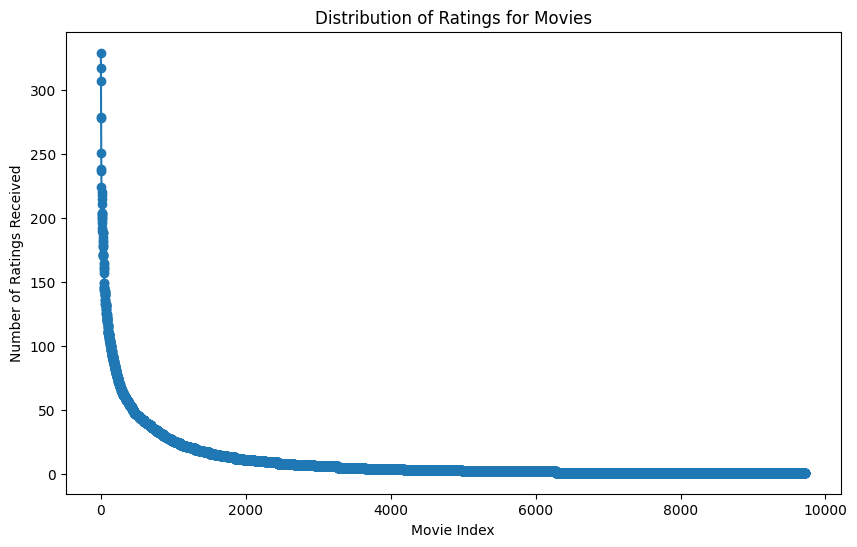

In [18]:
# Plot distribution of no of ratings for movies
plt.figure(figsize=(10, 6))
plt.plot(sorted_movies.values, marker='o', linestyle='-')
plt.xlabel('Movie Index')
plt.ylabel('Number of Ratings Received')
plt.title('Distribution of Ratings for Movies')
plt.show()

D. Plot the distribution of ratings among users: The X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user has rated.The requirement of the plot is similar to that in Question C.

In [19]:
user_ratings_per_movie = R.astype(bool).sum(axis=1)
user_ratings_per_movie

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Length: 610, dtype: int64

In [20]:
sorted_users = user_ratings_per_movie.sort_values(ascending=False)
sorted_users

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Length: 610, dtype: int64

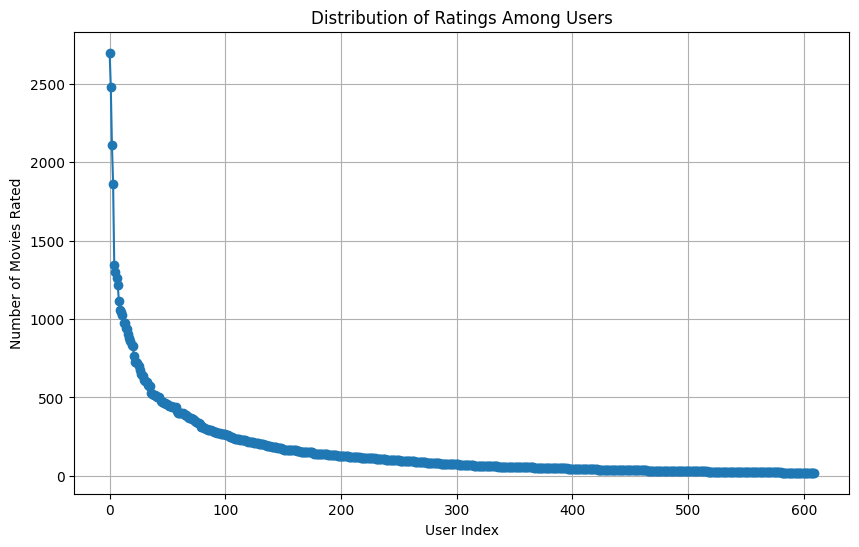

In [21]:
# Plot the distribution of the number of movies rated by users
plt.figure(figsize=(10, 6))
plt.plot(sorted_users.values, marker='o', linestyle='-')
plt.xlabel('User Index')
plt.ylabel('Number of Movies Rated')
plt.title('Distribution of Ratings Among Users')
plt.grid(True)
plt.show()

E. Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.

For Question C it is a monotonically decreasing graph which suggests long tail distribution. That is a small fraction of movies have recieved high rating while the majority of movies have fewer ratings. Recommender systems should be able to provide reccommendaions for both popular as well as less popular movies. Understanding the distribution can help provide recommendations for movies with fewer ratings as well. 

For Question D the distribution provides insight about the engagement level of different users. This is similar to the long tail distrubution wherin a small portion of users might contribute to significant portion of ratings. Recommender systems can help personalize recommendations based on user engagement levels.

F. Compute the variance of the rating values received by each movie: Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. <br><br>Briefly comment on the shape of the resulting histogram.

A. It is right skewed. 

In [22]:
# Calculate variance per movie 
var_per_movie = R.var(axis=0, skipna=True)

In [23]:
var_per_movie

movieId
1         3.759444
2         1.882813
3         0.923073
4         0.070285
5         0.762920
            ...   
193581    0.026230
193583    0.020082
193585    0.020082
193587    0.020082
193609    0.026230
Length: 9724, dtype: float64

In [24]:
# Bin the variance values 
bins_one = np.arange(0, var_per_movie.max()+0.5, 0.5)

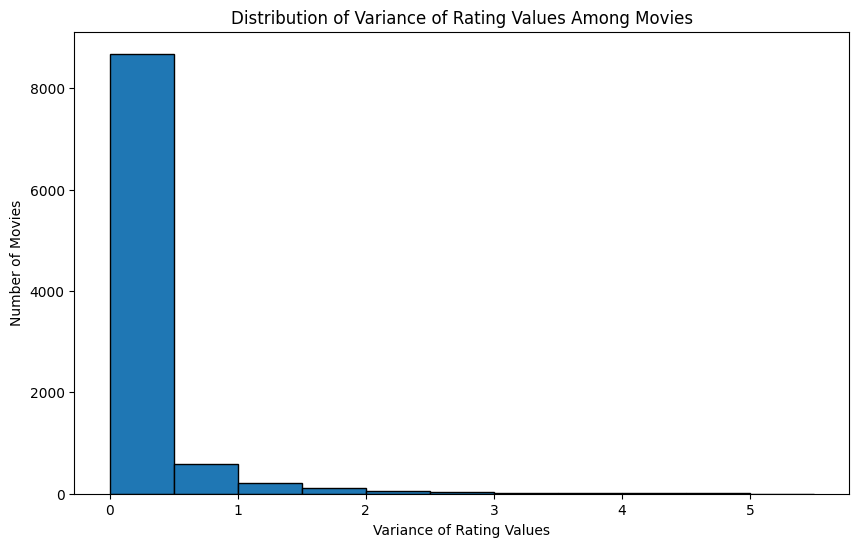

In [25]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(var_per_movie, bins=bins_one, edgecolor='black')
plt.xlabel('Variance of Rating Values')
plt.ylabel('Number of Movies')
plt.title('Distribution of Variance of Rating Values Among Movies')
plt.show()

# QUESTION 2

Understanding the Pearson Correlation Coefficient:

A Write down the formula for μu in terms of Iu and ruk

The Pearson-correlation coefficient between users u and v denoted by Pearson(u,v) captures the similarity between the rating vectors of users u and v. First some notation:
- Iu : Set of item indices for which ratings have been specified by user u;
- Iv : Set of item indices for which ratings have been specified by user v;
- μu: Mean rating for user u computed using her specified ratings;
- ruk: Rating of user u for item k.


$$
\mu_u = \frac{1}{|I_u|} \sum_{k \in I_u} r_{uk}
$$

B In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅? (Hint: Rating matrix R is sparse)

${I_u}∩{I_v}$ is the common movies that has been rated by both user u and user v. ${I_u}∩{I_v} = ∅$ This can be true since the matrix R is sparse and there is a high probability of movies being present that are not rated by user u as well as user v

# QUESTION 3

Understanding the Prediction function: Can you explain the reason behind mean-centering the raw ratings (${r_{vj}} − {μ_v}$) in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)

$$\hat{r}_{uj} = \mu_u + \sum_{v \in P_u} \frac{{\text{Pearson}(u, v) \cdot (r_{vj} - \mu_v)}}{{\sum_{v \in P_u} |\text{Pearson}(u, v)|}}$$

This helps mitigate user bias as some users might highly rate movies while some users might rate movies poorly. Mean centering helps m=to normalize the values and center the ratings around zero.

# Question 4

Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

In [27]:
reader = Reader(rating_scale = (0.5,5))
data = Dataset.load_from_df(df_ratings[['userId','movieId','rating']], reader)

In [30]:
k_range = range(2,101,2)

In [29]:
avg_rmse_list = []
avg_mae_list = []

In [31]:
kf = KFold(n_splits=10)

# 10-fold cv
for k in k_range:
    
    # Initialize KNN model
    algo = KNNBasic(k=k, sim_options={'name': 'pearson'})
    
    # CV
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    
    # Avg RMSE and MAE
    avg_rmse = np.mean(results['test_rmse'])
    avg_mae = np.mean(results['test_mae'])
    
    avg_rmse_list.append(avg_rmse)
    avg_mae_list.append(avg_mae)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

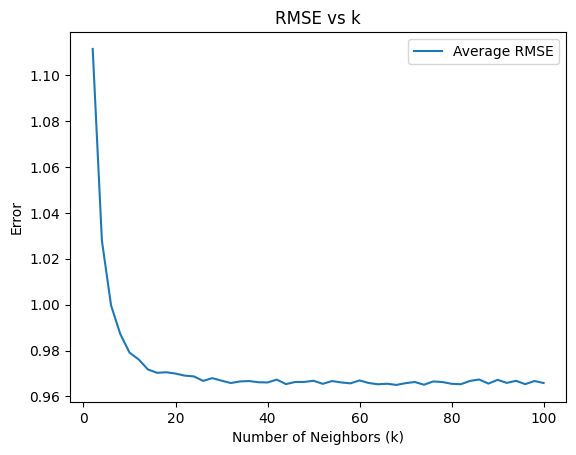

In [32]:
# Plot average RMSE and MAE against k
plt.plot(k_range, avg_rmse_list, label='Average RMSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.title('RMSE vs k')
plt.legend()
plt.show()

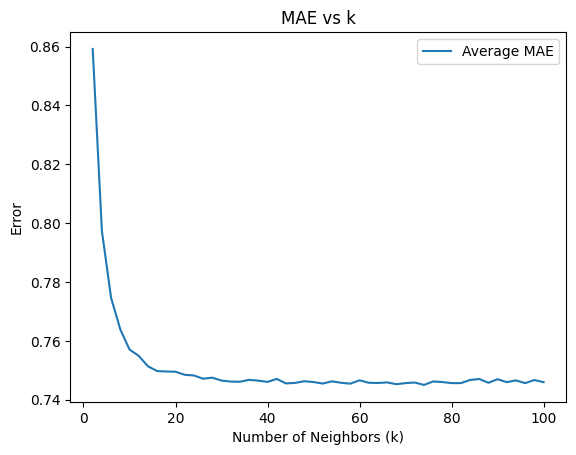

In [33]:
# Plot average RMSE and MAE against k
plt.plot(k_range, avg_mae_list, label='Average MAE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.title('MAE vs k')
plt.legend()
plt.show()

# Question 5 

Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.

The minimum value for which increase in k would not result in significant decrease in average RMSE or average MAE is k = 20. 

# Question 6


A k-NN collaborative filter on the ratings of the movies (i.e Popular, Unpopular or High-Variance) and evaluate each of the three models performance using 10-fold cross validation:

- Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.


In [34]:
# Popular Movie Trimming 
def popular_movie_trimming(data, threshold=2):
    movie_ratings_count = data.groupby('movieId').size()
    popular_movies = movie_ratings_count[movie_ratings_count > threshold].index.tolist()
    trimmed_data = data[data['movieId'].isin(popular_movies)]
    return trimmed_data

# Unpopular Movie Trimming 
def unpopular_movie_trimming(data, threshold=2):
    movie_ratings_count = data.groupby('movieId').size()
    unpopular_movies = movie_ratings_count[movie_ratings_count <= threshold].index.tolist()
    trimmed_data = data[data['movieId'].isin(unpopular_movies)]
    return trimmed_data

# High Variance Movie Trimming 
# Movies that have variance of at least 2 and have received at least 5 ratings in the entire dataset.
def high_variance_movie_trimming(data, variance_threshold=2, ratings_threshold=5):
    movie_variances = data.groupby('movieId')['rating'].var()
    high_variance_movies = movie_variances[(movie_variances >= variance_threshold) & 
                                            (data['movieId'].value_counts() >= ratings_threshold)].index.tolist()
    trimmed_data = data[data['movieId'].isin(high_variance_movies)]
    return trimmed_data

In [35]:
popular_trimmed_data = popular_movie_trimming(df_ratings)
unpopular_trimmed_data = unpopular_movie_trimming(df_ratings)
high_variance_trimmed_data = high_variance_movie_trimming(df_ratings)

In [37]:
# Loading the trimmed datasets
reader = Reader(rating_scale=(0,5))
popular_dataset = Dataset.load_from_df(popular_trimmed_data[['userId', 'movieId', 'rating']], reader)
unpopular_dataset = Dataset.load_from_df(unpopular_trimmed_data[['userId', 'movieId', 'rating']], reader)
high_variance_dataset = Dataset.load_from_df(high_variance_trimmed_data[['userId', 'movieId', 'rating']], reader)

In [38]:
# Range of k values 
k_values = np.arange(0,101,2)

In [39]:
def compute_avg_rmse(dataset):
    kf = KFold(n_splits=10)
    avg_rmse_values = []
    for k in k_values:
        rmse_values = []
        algo = KNNBasic(k=k, sim_options={'name': 'pearson', 'user_based': True})
        for trainset, testset in kf.split(dataset):
            algo.fit(trainset)
            predictions = algo.test(testset)
            rmse_values.append(accuracy.rmse(predictions, verbose=False))
        avg_rmse = np.mean(rmse_values)
        avg_rmse_values.append(avg_rmse)
    min_avg_rmse = min(avg_rmse_values)
    return predictions, avg_rmse_values, min_avg_rmse

In [40]:
# Compute average RMSE values for each trimmed subset
alldata_predictions, alldata_avg_rmse, alldata_min_avg_rmse = compute_avg_rmse(data)
popular_predictions, popular_avg_rmse, popular_min_avg_rmse = compute_avg_rmse(popular_dataset)
unpopular_predictions, unpopular_avg_rmse, unpopular_min_avg_rmse = compute_avg_rmse(unpopular_dataset)
high_variance_predictions, high_variance_avg_rmse, high_variance_min_avg_rmse = compute_avg_rmse(high_variance_dataset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

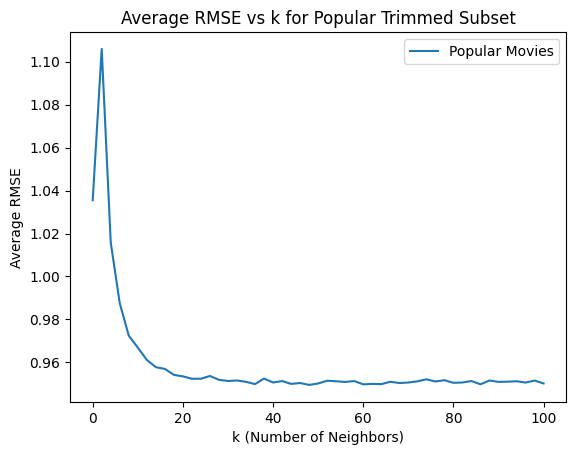

In [41]:
# Plots for RMSE against k for each trimmed subset
plt.plot(k_values, popular_avg_rmse, label='Popular Movies')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs k for Popular Trimmed Subset')
plt.legend()
plt.show()

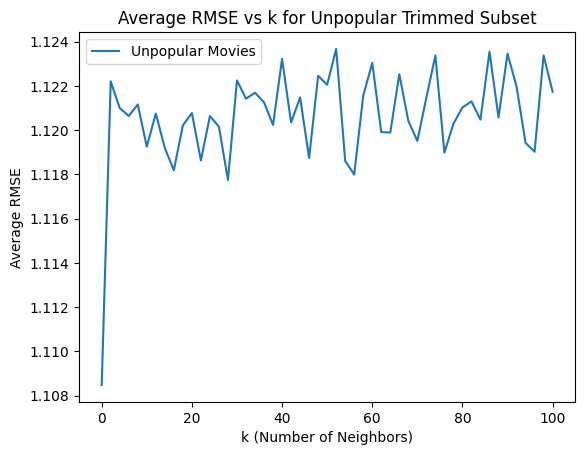

In [42]:
# Average RMSE against k for each trimmed subset
plt.plot(k_values, unpopular_avg_rmse, label='Unpopular Movies')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs k for Unpopular Trimmed Subset')
plt.legend()
plt.show()

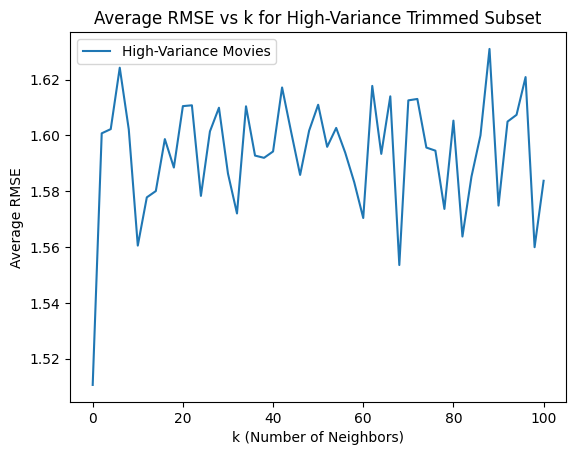

In [43]:
# Average RMSE against k for each trimmed subset
plt.plot(k_values, high_variance_avg_rmse, label='High-Variance Movies')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs k for High-Variance Trimmed Subset')
plt.legend()
plt.show()

In [44]:
# Report minimum average RMSE for each trimmed subset
print('Minimum Average RMSE for Popular Movies:', popular_min_avg_rmse)
print('Minimum Average RMSE for Unpopular Movies:', unpopular_min_avg_rmse)
print('Minimum Average RMSE for High-Variance Movies:', high_variance_min_avg_rmse)

Minimum Average RMSE for Popular Movies: 0.9495310161748665
Minimum Average RMSE for Unpopular Movies: 1.10848464155189
Minimum Average RMSE for High-Variance Movies: 1.5105485581079807


- Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These thresholds are applied only on the ground truth labels in held-out validation set. For each of the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds can be condensed into one plot per trimming option yielding only 4 plots.

In [45]:
def compute_roc_auc(predictions, threshold):
    true_labels = []
    predicted_labels = []
    for pred in predictions:
        true_labels.append(int(pred.r_ui >= threshold))
        predicted_labels.append(pred.est)
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

def plot_roc_curves(fprs, tprs, auc_scores, thresholds, subset_name):
    plt.figure(figsize=(10, 8))
    for i in range(len(thresholds)):
        plt.plot(fprs[i], tprs[i], label=f'Threshold={thresholds[i]}, AUC={auc_scores[i]:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {subset_name} Subset')
    plt.legend()
    plt.show()

In [46]:
# Threshold values
threshold_values = [2.5, 3, 3.5, 4]

# ROC curves and AUC for each trimmed subset
alldata_roc_data = []
popular_roc_data = []
unpopular_roc_data = []
high_variance_roc_data = []

In [47]:
for threshold in threshold_values:
    
    # ROC for all data
    alldata_fpr, alldata_tpr, alldata_auc = compute_roc_auc(alldata_predictions, threshold)
    alldata_roc_data.append((alldata_fpr, alldata_tpr, alldata_auc))
    
    # ROC for popular subset
    popular_fpr, popular_tpr, popular_auc = compute_roc_auc(popular_predictions, threshold)
    popular_roc_data.append((popular_fpr, popular_tpr, popular_auc))

    # ROC for unpopular subset
    unpopular_fpr, unpopular_tpr, unpopular_auc = compute_roc_auc(unpopular_predictions, threshold)
    unpopular_roc_data.append((unpopular_fpr, unpopular_tpr, unpopular_auc))

    # ROC for high variance subset
    high_variance_fpr, high_variance_tpr, high_variance_auc = compute_roc_auc(high_variance_predictions, threshold)
    high_variance_roc_data.append((high_variance_fpr, high_variance_tpr, high_variance_auc))

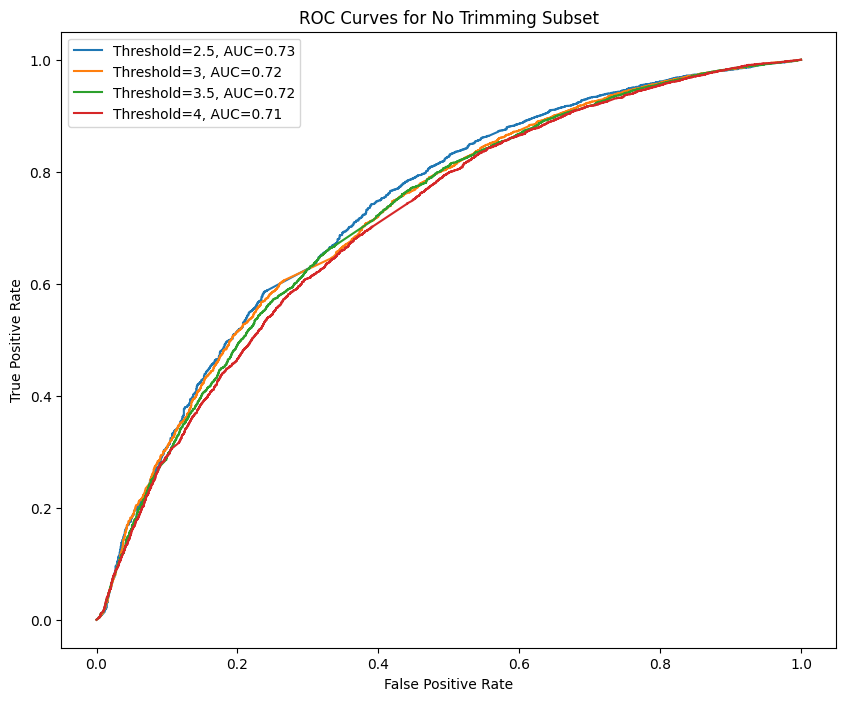

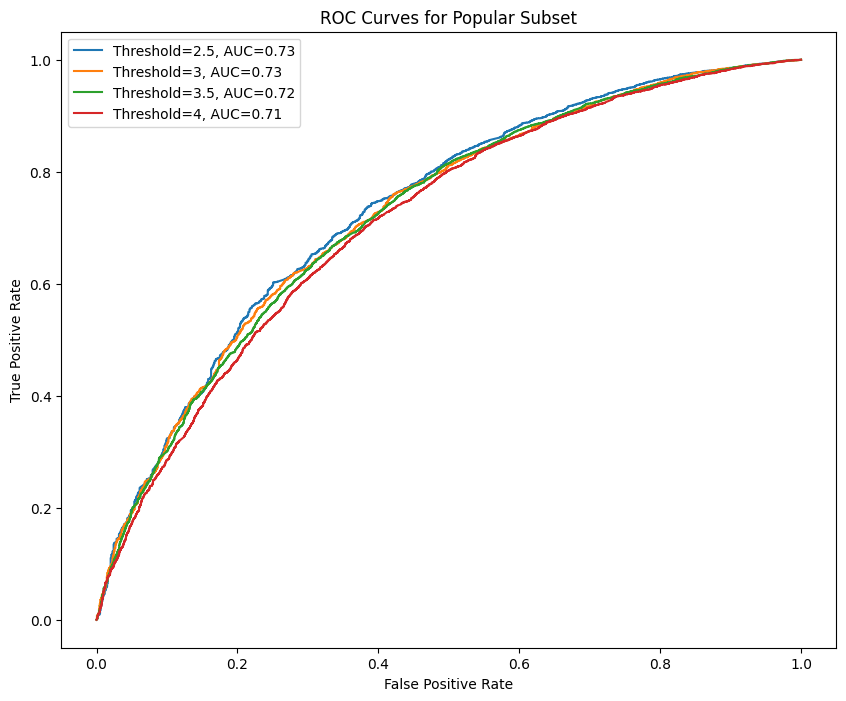

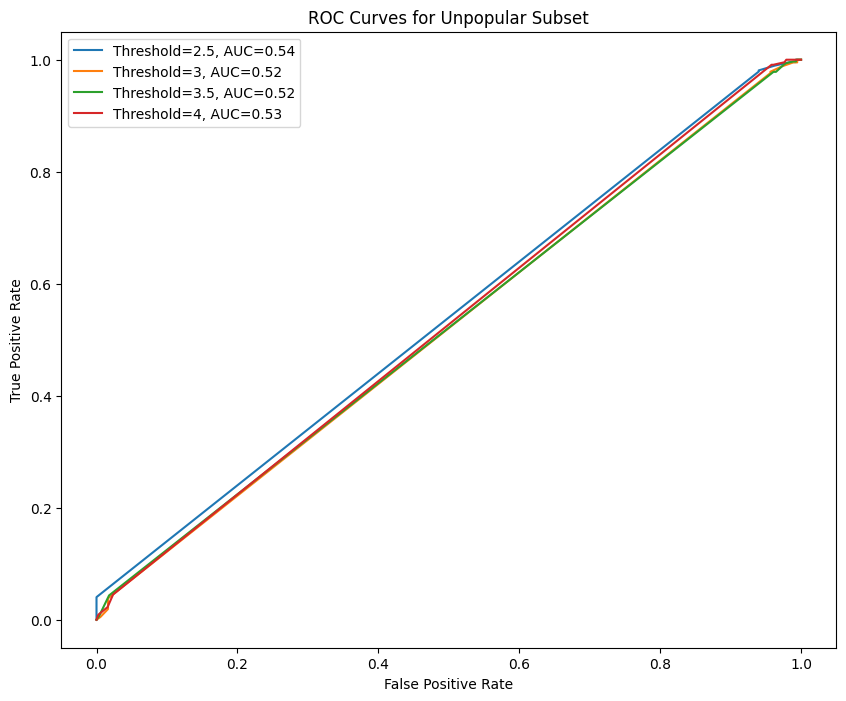

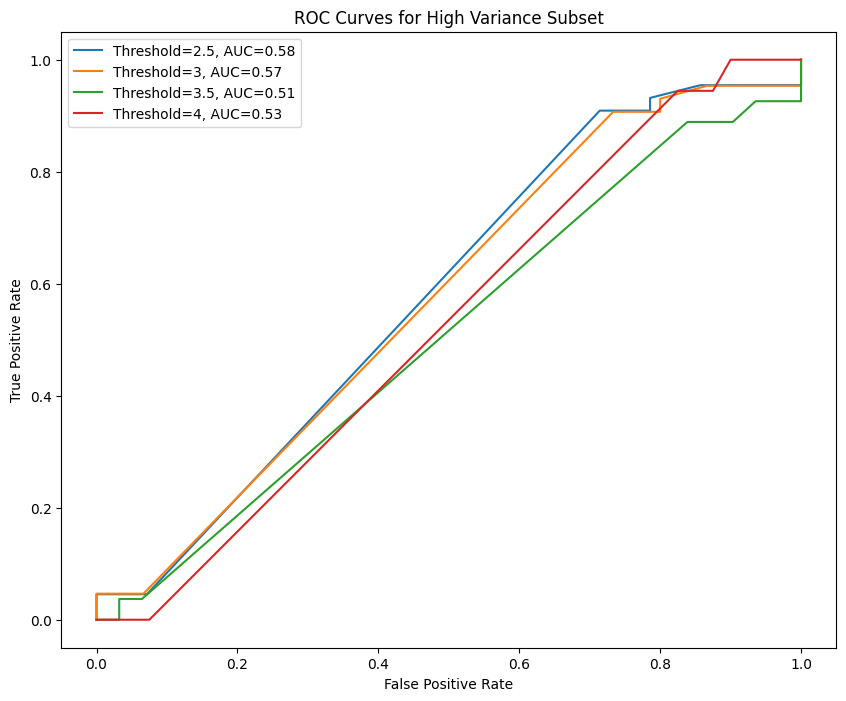

In [48]:
# ROC curves for each subset
plot_roc_curves(*zip(*alldata_roc_data), threshold_values, subset_name='No Trimming')
plot_roc_curves(*zip(*popular_roc_data), threshold_values, subset_name='Popular')
plot_roc_curves(*zip(*unpopular_roc_data), threshold_values, subset_name='Unpopular')
plot_roc_curves(*zip(*high_variance_roc_data), threshold_values, subset_name='High Variance')

# Question 7
Understanding the NMF cost function: Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

# Question 8
Designing the NMF Collaborative Filter

## A
Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes too long, you can increase the step size. Increasing it too much will result in poorer granularity in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Yaxis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

## B
Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

## C
Performance on trimmed dataset subsets: For each of Popular, Unpopular and High-Variance subsets

Design a NMF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.

Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

## D
Plot the ROC curves for the NMF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

# Question 9
Interpreting the NMF model: Perform Non-negative matrix factorization on
the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

# Question 10
Designing the MF Collaborative Filter

## A
Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

## B
Use the plot from the previous part to find the optimal number of latent factors. Optimal
number of latent factors is the value of k that gives the minimum average RMSE or the
minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal
number of latent factors same as the number of movie genres?

## C
Performance on dataset subsets: For each of Popular, Unpopular and High-Variance subsets

Design a MF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.

Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

# Question 11

## A
Design a naive collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

## B
Performance on dataset subsets: For each of Popular, Unpopular and High-Variance test subsets 

Design a naive collaborative filter for each trimmed set and evaluate its performance using 10-fold cross validation.

Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

# Question 12 
Comparing the most performant models across architecture: Plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based  ollaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.

# Question 13 
Use the provided helper code for loading and preprocessing Web10k data. Print out the number of unique queries in total and show distribution of relevance labels.

In [1]:
! pip install lightgbm

In [2]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np

# Load the dataset for one fold
def load_one_fole(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model 
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    return model.booster_.feature_importance(importance_type=importance_type)

Fold1: val:[0 1 2 3 4] count:[502741 310465 127541  17108   7078]
Fold2: val:[0 1 2 3 4] count:[499479 308384 126992  16867   6949]
Fold3: val:[0 1 2 3 4] count:[497813 308264 127576  17264   7287]
Fold4: val:[0 1 2 3 4] count:[498175 310318 128538  16956   7112]
Fold5: val:[0 1 2 3 4] count:[498844 307689 127157  17073   7098]


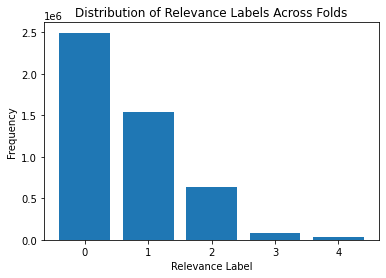

In [3]:
import os
import matplotlib.pyplot as plt

datapath = './MSLR-WEB10K'

total_counts = np.zeros(5, dtype=int)

# Loop through each fold
for fold_num in range(1, 6):
    # Load data for the current fold
    fold_path = os.path.join(datapath, f'Fold{fold_num}/')
    _, y_train, _, _, _, y_test, _, _ = load_one_fole(fold_path)

    # Calculate and print distribution of relevance labels for the current fold
    unique_labels, label_counts = np.unique(np.concatenate([y_train, y_test]), return_counts=True)
    print(f'Fold{fold_num}: val:{unique_labels} count:{label_counts}')

    # Update total counts
    total_counts += label_counts

# Combine counts across all folds into a single plot
relevance_labels = [0, 1, 2, 3, 4]

# Plot the total frequency of relevance labels
plt.bar(relevance_labels, total_counts)
plt.xlabel('Relevance Label')
plt.ylabel('Frequency')
plt.title('Distribution of Relevance Labels Across Folds')
plt.show()

In [4]:
# Print the combined counts
print("\nCombined counts across all folds:")
print("relevance label:  0                 1                  2                 3               4")
print(f"frequency:      {total_counts[0]}         {total_counts[1]}              {total_counts[2]}            {total_counts[3]}           {total_counts[4]}")


Combined counts across all folds:
relevance label:  0                 1                  2                 3               4
frequency:      2497052         1545120              637804            85268           35524


# Question 14
For each of the five provided folds, train a LightGBM model using the ’lambdarank’ objective. After
training, evaluate and report the model’s performance on the test set using nDCG@3, nDCG@5 and
nDCG@10

In [6]:
import lightgbm as lgb

datapath = './MSLR-WEB10K'

results = []

for fold_num in range(1, 6):
    # Load data for the current fold
    fold_path = os.path.join(datapath, f'Fold{fold_num}/')
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fole(fold_path)

    # LightGBM model with 'lambdarank' objective
    params = {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5, 10], 'verbose': 0}
    fold_train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
    fold_test_data = lgb.Dataset(X_test, label=y_test, group=group_test, free_raw_data=False)

    lgb_model = lgb.train(params, fold_train_data, valid_sets=[fold_test_data])

    # Evalauting the model on the test set
    ndcg3 = compute_ndcg_all(lgb_model, X_test, y_test, qid_test, k=3)
    ndcg5 = compute_ndcg_all(lgb_model, X_test, y_test, qid_test, k=5)
    ndcg10 = compute_ndcg_all(lgb_model, X_test, y_test, qid_test, k=10)

    results.append({'fold': fold_num, 'ndcg@3': ndcg3, 'ndcg@5': ndcg5, 'ndcg@10': ndcg10})

print("\nEvaluation Results:")
for r in results:
    print(f"Fold {r['fold']}: nDCG@3 = {r['ndcg@3']:.4f}, nDCG@5 = {r['ndcg@5']:.4f}, nDCG@10 = {r['ndcg@10']:.4f}")





Evaluation Results:
Fold 1: nDCG@3 = 0.4565, nDCG@5 = 0.4633, nDCG@10 = 0.4829
Fold 2: nDCG@3 = 0.4538, nDCG@5 = 0.4572, nDCG@10 = 0.4767
Fold 3: nDCG@3 = 0.4491, nDCG@5 = 0.4583, nDCG@10 = 0.4759
Fold 4: nDCG@3 = 0.4612, nDCG@5 = 0.4663, nDCG@10 = 0.4877
Fold 5: nDCG@3 = 0.4697, nDCG@5 = 0.4715, nDCG@10 = 0.4905


# Question 15
For each of the five provided folds, list top 5 most important features of the model based on
the importance score. Please use model.booster .feature importance(importance type=’gain’) as
demonstrated here for retrieving importance score per feature. You can also find helper code in the
provided notebook.

In [7]:
datapath = './MSLR-WEB10K'

for fold_num in range(1, 6):
    # Load data for the current fold
    fold_path = os.path.join(datapath, f'Fold{fold_num}/')
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fole(fold_path)

    # LightGBM model with 'lambdarank' objective
    params = {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5, 10], 'verbose': 0}
    fold_train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
    fold_test_data = lgb.Dataset(X_test, label=y_test, group=group_test, free_raw_data=False)

    lgb_model = lgb.train(params, fold_train_data, valid_sets=[fold_test_data])

    # Get feature importance
    feature_importance = lgb_model.feature_importance(importance_type="gain")

    # Find and print the top 5 most important features
    top_features_indices = np.argsort(feature_importance)[::-1][:5]
    top_features = [f"Feature {idx + 1}" for idx in top_features_indices]
    
    print(f"\nTop 5 features for Fold {fold_num} based on importance score:")
    for feature in top_features:
        print(feature)


Top 5 features for Fold 1 based on importance score:
Feature 134
Feature 8
Feature 108
Feature 55
Feature 130

Top 5 features for Fold 2 based on importance score:
Feature 134
Feature 8
Feature 55
Feature 108
Feature 130

Top 5 features for Fold 3 based on importance score:
Feature 134
Feature 55
Feature 108
Feature 130
Feature 8

Top 5 features for Fold 4 based on importance score:
Feature 134
Feature 8
Feature 55
Feature 130
Feature 129

Top 5 features for Fold 5 based on importance score:
Feature 134
Feature 8
Feature 55
Feature 108
Feature 130


# Question 16.1
For each of the five provided folds:
- Remove the top 20 most important features according to the computed importance score in
the question 15. Then train a new LightGBM model on the resulted 116 dimensional query-
url data. Evaluate the performance of this new model on the test set using nDCG. Does
the outcome align with your expectations? If not, please share your hypothesis regarding the
potential reasons for this discrepancy.

In [8]:
datapath = './MSLR-WEB10K'

for fold_num in range(1, 6):
    # Load data for the current fold
    fold_path = os.path.join(datapath, f'Fold{fold_num}/')
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fole(fold_path)

    # LightGBM model with 'lambdarank' objective
    params = {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5, 10], 'verbose': 0}
    fold_train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
    fold_test_data = lgb.Dataset(X_test, label=y_test, group=group_test, free_raw_data=False)

    lgb_model = lgb.train(params, fold_train_data, valid_sets=[fold_test_data])

    # Get feature importance
    feature_importance = lgb_model.feature_importance(importance_type="gain")

    # Get the indices of the top 20 features
    top20_indices = np.argsort(feature_importance)[::-1][:20]

    # Remove top 20 features
    X_train_top20 = np.delete(X_train.toarray(), top20_indices, axis=1)
    X_test_top20 = np.delete(X_test.toarray(), top20_indices, axis=1)

    model_top20 = lgb.train(params, lgb.Dataset(X_train_top20, label=y_train, group=group_train, free_raw_data=False))

    # Evaluate the performance on the test set using nDCG
    ndcg_top20 = compute_ndcg_all(model_top20, X_test_top20, y_test, qid_test, k=10)
    print(f"\nFold {fold_num} - After removing top 20 features: nDCG@10 = {ndcg_top20:.4f}")


Fold 1 - After removing top 20 features: nDCG@10 = 0.4081

Fold 2 - After removing top 20 features: nDCG@10 = 0.4046

Fold 3 - After removing top 20 features: nDCG@10 = 0.4114

Fold 4 - After removing top 20 features: nDCG@10 = 0.4123

Fold 5 - After removing top 20 features: nDCG@10 = 0.4169


# Question 16.2
For each of the five provided folds:
- Remove the 60 least important features according to the computed importance score in the
question 15. Then train a new LightGBM model on the resulted 76 dimensional query-url data.
Evaluate the performance of this new model on the test set using nDCG. Does the outcome
align with your expectations? If not, please share your hypothesis regarding the potential
reasons for this discrepancy.

In [10]:
datapath = './MSLR-WEB10K'

for fold_num in range(1, 6):
    # Load data for the current fold
    fold_path = os.path.join(datapath, f'Fold{fold_num}/')
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fole(fold_path)

    # LightGBM model with 'lambdarank' objective
    params = {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [3, 5, 10], 'verbose': 0}
    fold_train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
    fold_test_data = lgb.Dataset(X_test, label=y_test, group=group_test, free_raw_data=False)

    lgb_model = lgb.train(params, fold_train_data, valid_sets=[fold_test_data])

    # Get feature importance
    feature_importance = lgb_model.feature_importance(importance_type="gain")

    # Get the indices of the bottom 60 features
    bottom60_indices = np.argsort(feature_importance)[:60]

    # Remove top 20 features
    X_train_bottom60 = np.delete(X_train.toarray(), bottom60_indices, axis=1)
    X_test_bottom60 = np.delete(X_test.toarray(), bottom60_indices, axis=1)

    model_bottom60 = lgb.train(params, lgb.Dataset(X_train_bottom60, label=y_train, group=group_train, free_raw_data=False))

    # Evaluate the performance on the test set using nDCG
    ndcg_bottom60 = compute_ndcg_all(model_bottom60, X_test_bottom60, y_test, qid_test, k=10)
    print(f"\nFold {fold_num} - After removing bottom 60 features: nDCG@10 = {ndcg_bottom60:.4f}")


Fold 1 - After removing bottom 60 features: nDCG@10 = 0.4821

Fold 2 - After removing bottom 60 features: nDCG@10 = 0.4772

Fold 3 - After removing bottom 60 features: nDCG@10 = 0.4774

Fold 4 - After removing bottom 60 features: nDCG@10 = 0.4889

Fold 5 - After removing bottom 60 features: nDCG@10 = 0.4910
